# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

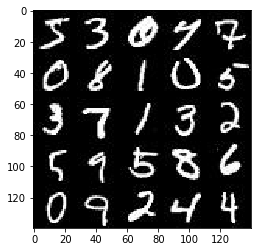

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

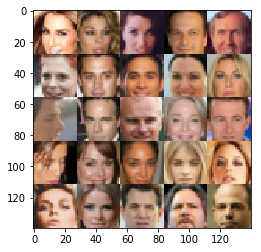

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\adity_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, in_learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Layer 1 in: 28x28x(1|3)
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, stddev=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 in: 7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        # Layer 1 out: 4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        # Layer 2 out: 8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        # Layer 3 out: 16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = tf.maximum(alpha * layer_4, layer_4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 2.7271
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.6089
Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 1.7811
Epoch 1/2... Discriminator Loss: 0.6685... Generator Loss: 2.8189
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.3361
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 4.1829
Epoch 1/2... Discriminator Loss: 1.2935... Generator Loss: 0.6058
Epoch 1/2... Discriminator Loss: 0.9402... Generator Loss: 1.3053
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 2.0406
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.5698


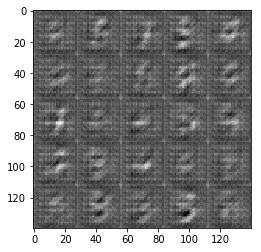

Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 0.9332... Generator Loss: 1.4069
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 1.2605
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 2.8373
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 1.5492
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.5728
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.4169
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.7836


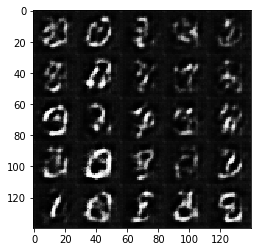

Epoch 1/2... Discriminator Loss: 0.9798... Generator Loss: 1.1582
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 1.2213
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 1.5145... Generator Loss: 0.4144
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 1.2345
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.1733
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.4340... Generator Loss: 0.4657
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 1.2609


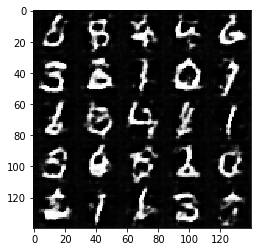

Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.9067


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7595... Generator Loss: 0.2955
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7588


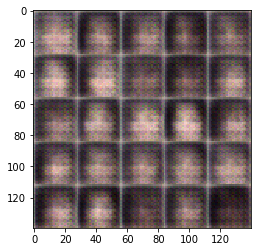

Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6256


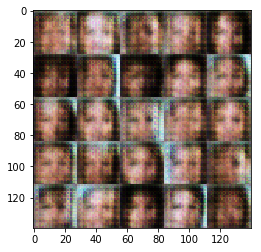

Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 1.7488
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9690


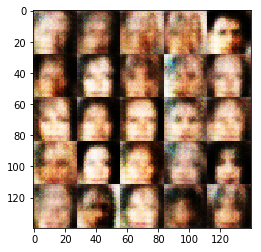

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7425


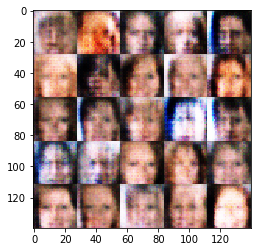

Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8359


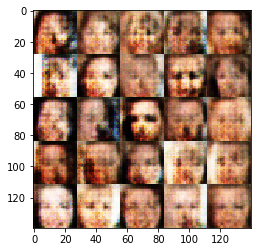

Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 1.0085
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.3179


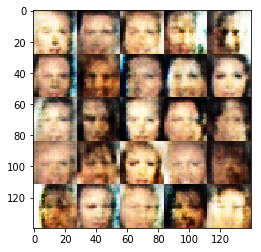

Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.8957


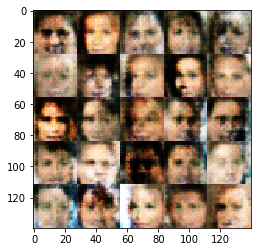

Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.6862


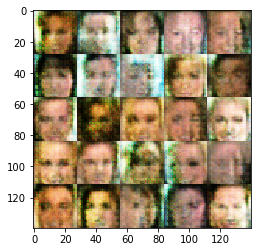

Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.5543


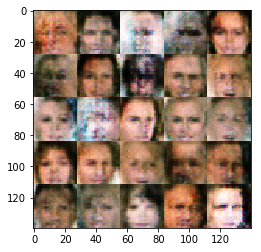

Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.9386


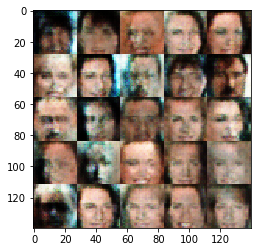

Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.7348


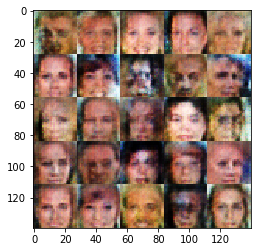

Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.9261


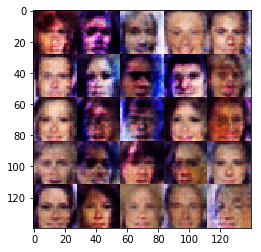

Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.0524


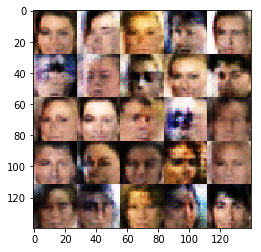

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.0886


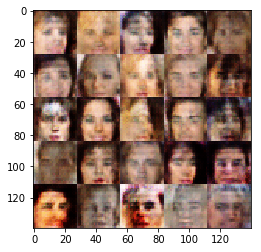

Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.7712


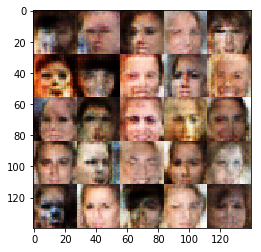

Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.0805


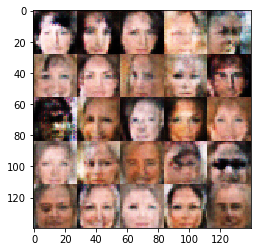

Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7361


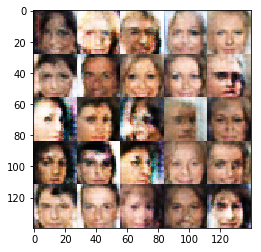

Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.5371


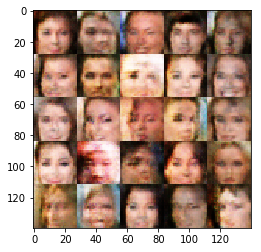

Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.6733


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.35


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.